## WHO Mortality Database Visualization

The WHO Mortality database, available at https://www.who.int/data/data-collection-tools/who-mortality-database, is a compilation of annual data reported to WHO by countries around the world from 1950 to 2019. Not all countries are represented in this data.

All analyses, interpretations, and conclusions are my own.

In [1]:
import seaborn as sns
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
path = r'/PATH/TO/DB/who_mortality.db'
conn = sqlite3.connect(path)

The WHO mortality database breaks down deaths by cause, country, year, and age group. It also includes aggregated information, with Cause 'AAA' indicating all causes combined for the given country, and the column Deaths1 reporting deaths for all ages.

The database includes three tables: the mortality data, country codes and corresponding country names, and population data for a subset of countries.

In [3]:
conn.execute("""SELECT name FROM sqlite_master WHERE type='table'""").fetchall()

[('data',), ('country_codes',), ('population',)]

Here is a sample of the mortality data:

In [4]:
df = pd.read_sql_query('''SELECT * FROM data LIMIT 5''', conn)

In [5]:
df[df.columns[:15]].head()

,index,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,Deaths2,Deaths3,Deaths4,Deaths5
0,0,1125,None,None,2000,103,A00,1,2,8,2,0,0,None,None
1,1,1125,None,None,2000,103,A01,1,2,8,27,8,2,None,None
2,2,1125,None,None,2000,103,A02,1,2,8,3,1,0,None,None
3,3,1125,None,None,2000,103,A03,1,2,8,2,0,0,None,None
4,4,1125,None,None,2000,103,A04,1,2,8,16,8,5,None,None


### Top 10 Countries with Highest Mortality Rates in 2015

Here we will use information from all three tables to determine which countries had the highest mortality rates in 2015.

It is important to note that there is not population data for all countries that have mortality data, and not all countries in the world are represented.

In [6]:
# number of countries reporting mortality data in 2015
pd.read_sql_query('''SELECT COUNT(DISTINCT(Country)) FROM data WHERE Year = 2015''', conn).iloc[0][0]

105

In [7]:
# number of countries reporting population data in 2015
pd.read_sql_query('''SELECT COUNT(DISTINCT(Country)) FROM population WHERE Year = 2015''', conn).iloc[0][0]

65

In [8]:
sql = '''SELECT d.Country, SUM(d.Deaths1) as Deaths, pop.Population, country_codes.name as country_name
           FROM data as d
           JOIN(
             SELECT SUM(Pop1) AS Population, Country
               FROM population
               WHERE YEAR = 2015
               GROUP BY Country
           ) AS pop 
             ON pop.Country = d.Country
           JOIN country_codes
             ON country_codes.Country = d.Country
           WHERE Cause = 'AAA'
             AND YEAR = 2015
           GROUP BY d.Country;'''
df = pd.read_sql_query(sql, conn)

In [9]:
df['mortality_rate'] = df['Deaths'] / df['Population']

In [10]:
df = df.sort_values(by='mortality_rate', ascending=False)

In [11]:
df = df.head(10)

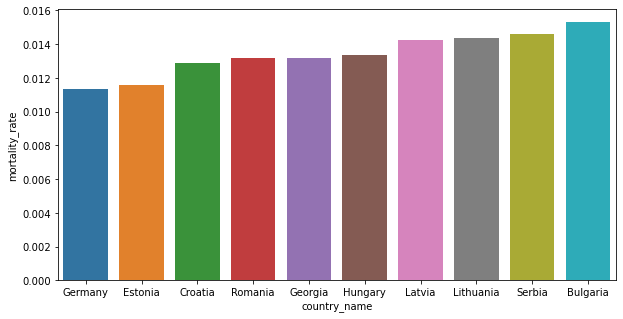

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(x='country_name', y='mortality_rate', data=df, order=df.sort_values('mortality_rate').country_name)

### Number of Deaths Per Year Worldwide

In [13]:
sql = '''SELECT SUM(Deaths1) as Deaths1, COUNT(DISTINCT(Country)) as countries_reported, Year
         FROM data
         WHERE Cause = 'AAA'
         GROUP BY Year;'''
df = pd.read_sql_query(sql, conn)

Looking at number of deaths alone shows an unexpected trend, with deaths starting near zero in 1988 and increasing dramatically with time. However, comparing with the number of countries reported each year shows that the trend is largely due to the fact that the number of countries initially included is small. For recent years, there appears to be a lag in reporting of many countries.

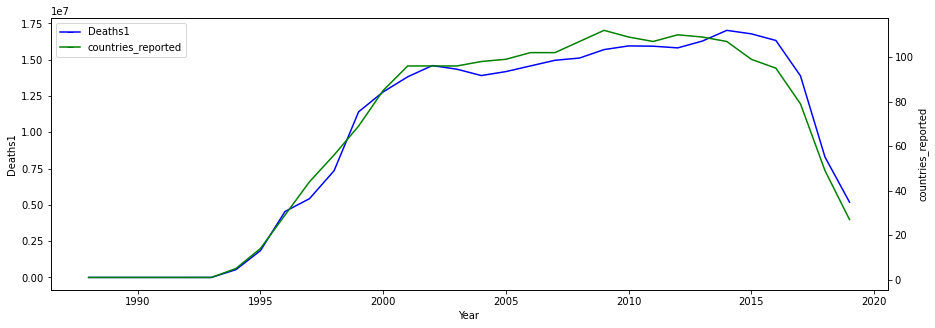

In [14]:
plt.figure(figsize=(15,5))
g = sns.lineplot(x='Year', y='Deaths1', data=df, color='b')
sns.lineplot(x='Year', y='countries_reported', data=df, ax=g.axes.twinx(), color='g')
g.legend(handles=[Line2D([], [], marker='_', color='b', label='Deaths1'), Line2D([], [], marker='_', color='g', label='countries_reported')])